In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
from model_funcs import character_error_rate, word_error_rate, ctc_loss_lambda_func, build_CRNN_model
from data_processing import create_datasets, batch_generator
from configs import Configs 
%run "tester_functions.ipynb"

In [2]:
# all for GPU dynamic VRAM allocation 
K.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
# Cell for creating tensorflow datasets to allow for variable images and ground truth labels
c = Configs()
# get complete dataset
batch_size = 10
image_height = 256
total_dataset = create_datasets(c.image_paths, c.label_path, batch_size, image_height, c.augmentation_probability, c.cv_add_data)
# get indivdual batches
training_datasets = total_dataset.map(lambda train, cv:train)
cv_datasets = total_dataset.map(lambda train, cv: cv)


(256, 411, 1)
(256, 645, 1)
(256, 441, 1)
(256, 644, 1)
Batch X shape: (10, 256, 4947, 1)
Batch Y shape: (10, 283)
(256, 270, 1)
(256, 569, 1)
Batch X shape: (10, 256, 3986, 1)
Batch Y shape: (10, 285)
(256, 283, 1)
(256, 650, 1)
Batch X shape: (10, 256, 3565, 1)
Batch Y shape: (10, 470)
(256, 279, 1)
(256, 650, 1)
(256, 289, 1)
(256, 745, 1)
(256, 289, 1)
(256, 663, 1)
(256, 357, 1)
(256, 635, 1)
(256, 373, 1)
(256, 706, 1)
(256, 423, 1)
(256, 715, 1)
(256, 456, 1)
(256, 793, 1)
Batch X shape: (1, 256, 1822, 1)
Batch Y shape: (1, 45)
(256, 256, 1)
(256, 648, 1)
(256, 279, 1)
(256, 683, 1)
(256, 277, 1)
(256, 568, 1)
(256, 276, 1)
(256, 713, 1)
(256, 294, 1)
(256, 747, 1)
(256, 371, 1)
(256, 644, 1)
(256, 323, 1)
(256, 729, 1)
(256, 453, 1)
(256, 690, 1)
(256, 432, 1)
(256, 728, 1)
(256, 251, 1)
(256, 599, 1)


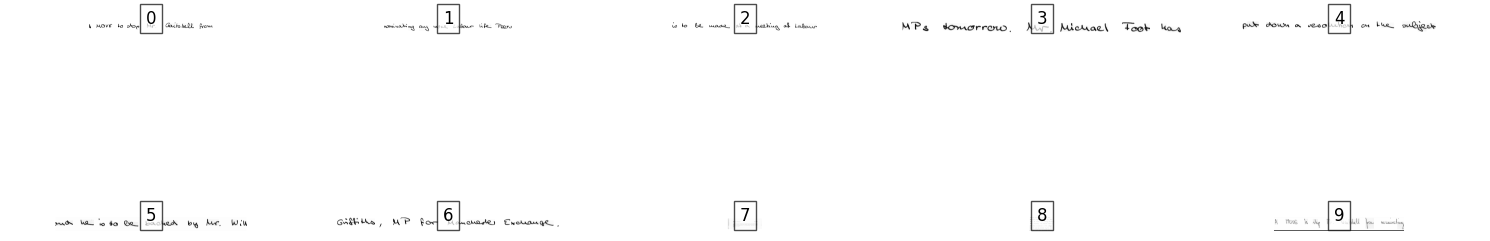

(256, 277, 1)
(256, 683, 1)
(256, 263, 1)
(256, 606, 1)


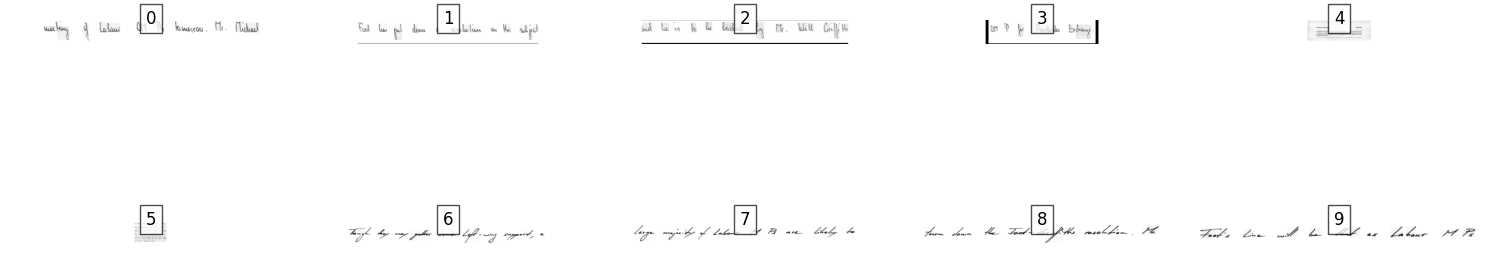

(256, 289, 1)
(256, 714, 1)
(256, 291, 1)
(256, 685, 1)


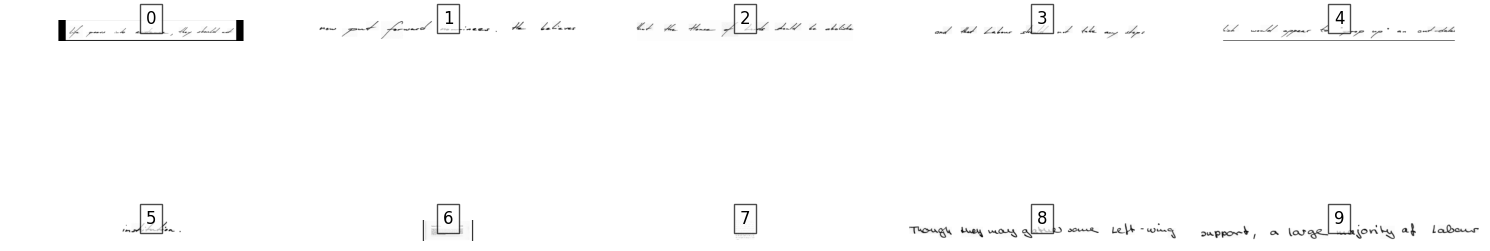

(256, 375, 1)
(256, 676, 1)
(256, 366, 1)
(256, 747, 1)
(256, 427, 1)
(256, 808, 1)
(256, 424, 1)
(256, 713, 1)


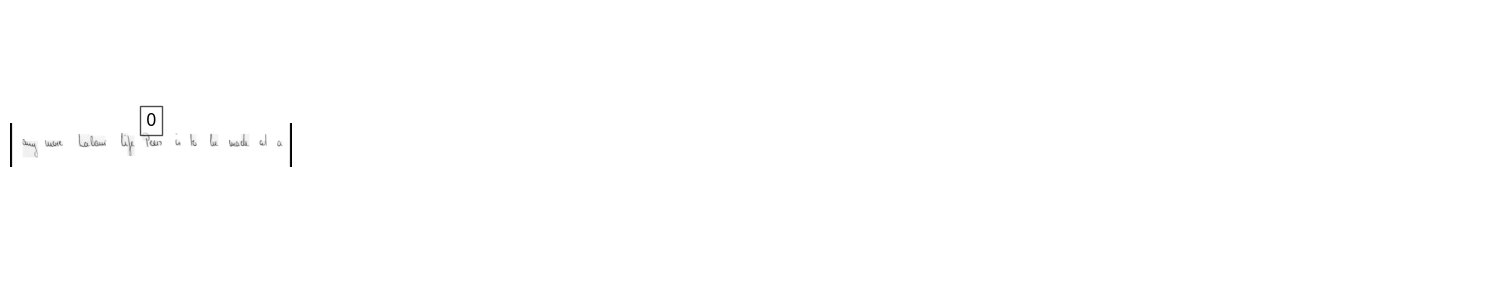

(256, 259, 1)
(256, 677, 1)
(256, 284, 1)
(256, 763, 1)
(256, 301, 1)
(256, 582, 1)
(256, 273, 1)
(256, 810, 1)
(256, 287, 1)
(256, 784, 1)
(256, 379, 1)
(256, 577, 1)
(256, 351, 1)
(256, 734, 1)


In [4]:
# test batches are legit
for x, y in training_datasets.take(3):
    print("Batch X shape:", x.shape)
    print("Batch Y shape:", y.shape)
for x, y in cv_datasets.take(1):
    print("Batch X shape:", x.shape)
    print("Batch Y shape:", y.shape)
    

# test batches are legit
for x, y in training_datasets.take(3):
    inpute_batch_displayer(x)
for x, y in cv_datasets.take(1):
    inpute_batch_displayer(x)

In [ ]:
# load in model and get it ready for training
model = build_CRNN_model((c.image_height, None, 1), c.num_classes)
learn_rate = c.learning_rate
# define the model optimizer, loss function and metrics we want to track
model.compile(optimizer=Adam(learning_rate=learn_rate),
              loss=ctc_loss_lambda_func,
              metrics=['accuracy' , character_error_rate, word_error_rate])

# Callbacks for selecting the best model and early stopping if more training does nothing 
checkpoint = ModelCheckpoint('OCR model', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [ ]:
# number of epochs for training 
epochs = c.epoch_num 
epochs = 1
model = model.fit(
    training_datasets,
    epochs=epochs,
    validation_data=cv_datasets,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

In [ ]:
# save the model to be able to import later
model.save('OCR model')